## Data Augmentation in ELPV Dataset using DCGAN

Objectives:
1. Load Images belonging to one class of elpv dataset
2. Define DCGAN Architecture
3. Train DCGAN:<br>
    3.a) Save G and D loss for each epoch<br>
    3.b) Save G checkpoint after every 10 epochs<br>
    3.c) Save 10 generated images after every 10 epochs
4. Generate new images using trained generator

Notes:
- Input shape of Discriminator and Output of Generator is 256x256

DO NOT UNCOMMENT
###### !rm -rf /kaggle/working

In [23]:
# !rm -rf /kaggle/working/*

In [13]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

# For mac
# from tensorflow.keras.optimizers.legacy import Adam
# For windows
from tensorflow.keras.optimizers import Adam

import time
from IPython import display

In [14]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [15]:
# Dataset folder path
DATASET_FOLDER_PATH = "/kaggle/input/elpv-classwise/2"

# Define directories for outputs
checkpoint_dir = '/kaggle/working/model_checkpoints/'
generated_images_dir = '/kaggle/working/generator_outputs/'

In [16]:
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

In [17]:
# Hyperparameters
noise_dim = 100
IMG_SIZE = 256
channels_img = 1
# lr = 0.0002
lr_D = 0.000003
lr_G = 0.0003
BATCH_SIZE = 64
EPOCHS = 200
features_gen = 64
features_disc = 64

## 1. Load Images belonging to one class of elpv dataset

In [18]:
file_paths = [os.path.join(DATASET_FOLDER_PATH, fname) for fname in os.listdir(DATASET_FOLDER_PATH)]

# Step 3: Create a dataset of file paths
file_paths_dataset = tf.data.Dataset.from_tensor_slices(file_paths)

# Step 4: Define a function to load and preprocess the images
def load_and_preprocess_image(file_path):
    # Load the raw data from the file
    img = tf.io.read_file(file_path)
    
    # Decode the JPEG/PNG image to a uint8 tensor
    img = tf.image.decode_jpeg(img, channels=channels_img)  # Change channels according to your images
    
    # Normalize the pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize the image to your desired size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Specify your desired height and width
    return img

# Step 5: Map the preprocessing function to the dataset
image_dataset = file_paths_dataset.map(load_and_preprocess_image)

# Optionally, shuffle and batch the dataset
train_dataset = image_dataset.shuffle(buffer_size=len(file_paths), seed=42).batch(BATCH_SIZE)

## 2. Define DCGAN Architecture

### 2.a) Generator

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Input(shape=(100,)))
    model.add(layers.Dense(8 * 8 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='relu'))
    assert model.output_shape == (None, 128, 128, 1)

    # Additional upsampling layer to reach 256x256
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 1)

    return model

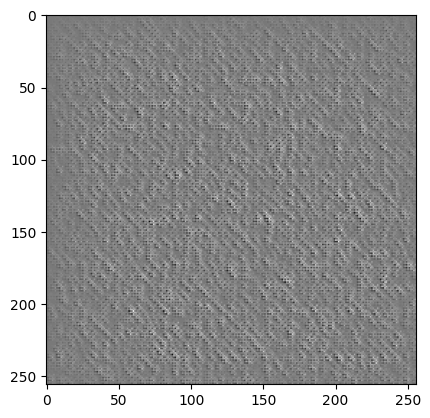

In [20]:
# Use the (as yet untrained) generator to create an image.

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [21]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 1)    │           800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 1)    │            25 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,857 (10.61 MB)

 Trainable params: 2,747,641 (10.48 MB)

 Non-trainable params: 33,216 (129.75 KB)

### 2.b) Discriminator

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Input(shape=(256, 256, 1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [23]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
# The model will be trained to output positive values for real images, and negative values for fake images.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-7.6075376e-05]], shape=(1, 1), dtype=float32)


In [24]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,434,433 (16.92 MB)

 Trainable params: 4,434,433 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

### 2.c) Define the loss and optimizers

In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
# Discriminator Loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [27]:
# Generator Loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
# Initialize optimizers

generator_optimizer = Adam(learning_rate=lr_G)
discriminator_optimizer = Adam(learning_rate=lr_D)

In [29]:
# Save Checkpoints

# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 3. Train DCGAN

In [30]:
num_examples_to_generate = 10

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Return the discriminator and generator losses
    return disc_loss, gen_loss

In [32]:
# Define training function

def train(dataset, epochs):
    # Lists to store discriminator and generator losses
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        start = time.time()
        
        # Variables to store total discriminator and generator losses for this epoch
        epoch_d_loss = 0
        epoch_g_loss = 0
        
        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch)
            
            # Accumulate losses for this batch
            epoch_d_loss += d_loss
            epoch_g_loss += g_loss
        
        # Calculate average losses for this epoch
        epoch_d_loss /= len(dataset)
        epoch_g_loss /= len(dataset)
        
        # Append average losses to the lists
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)

        # Display generated images
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_dir_epoch = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}')
            if not os.path.exists(checkpoint_dir_epoch):
                os.makedirs(checkpoint_dir_epoch)
            checkpoint.save(file_prefix=os.path.join(checkpoint_dir_epoch, "ckpt"))

        print(f'Epoch [{epoch+1}/{epochs}]: {round(time.time()-start, 1)}s  Loss D: {round(epoch_d_loss.numpy(), 4)},  Loss G: {round(epoch_g_loss.numpy(), 4)}')
        
        # Visualize loss after 50 epochs
        if (epoch + 1) % 50 == 0:
            visualize_losses(d_losses, g_losses)
            print(f"Discriminator Learning Rate: {lr_D}")
            print(f"Generator Learning Rate: {lr_G}")
            

    # Generate after the final epoch
    generate_and_save_images(generator,
                             epochs,
                             seed)
    
    return d_losses, g_losses

In [33]:
# Generate and save images

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.show()
    
    
    # Save images
    
#     # Create a directory for the current epoch if it doesn't exist
#     epoch_dir = os.path.join(generated_images_dir, f'epoch_{epoch}')
#     if not os.path.exists(epoch_dir):
#         os.makedirs(epoch_dir)
    
#     for i in range(predictions.shape[0]):
#         image_path = os.path.join(epoch_dir, 'image_{:03d}.png'.format(i))
#         plt.savefig(image_path)

In [34]:
# Define a function to visualize discriminator and generator losses
def visualize_losses(d_losses, g_losses):
    epochs = range(1, len(d_losses) + 1)
    plt.plot(epochs, d_losses, label='Discriminator Loss')
    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Discriminator and Generator Losses')
    plt.legend()
    plt.show()

2024-05-03 05:19:22.719466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


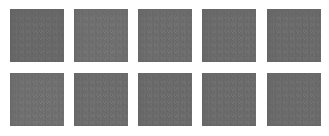

Epoch [1/150]: 23.0s  Loss D: 1.3909000158309937,  Loss G: 0.6650000214576721


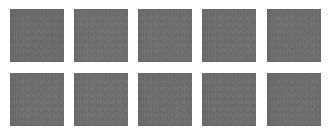

Epoch [2/150]: 6.1s  Loss D: 1.3646999597549438,  Loss G: 0.6283000111579895


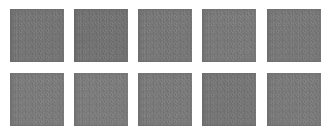

Epoch [3/150]: 6.2s  Loss D: 1.319100022315979,  Loss G: 0.619700014591217


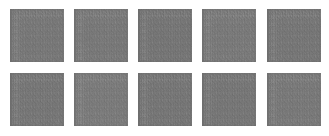

Epoch [4/150]: 6.3s  Loss D: 1.2786999940872192,  Loss G: 0.6097999811172485


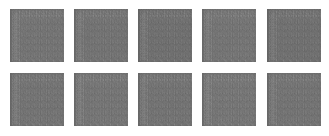

Epoch [5/150]: 6.1s  Loss D: 1.26010000705719,  Loss G: 0.5802000164985657


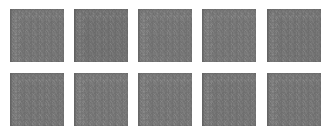

Epoch [6/150]: 6.1s  Loss D: 1.2484999895095825,  Loss G: 0.5526000261306763


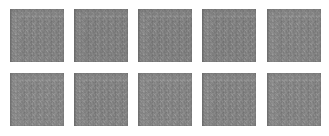

Epoch [7/150]: 6.1s  Loss D: 1.2452000379562378,  Loss G: 0.5364000201225281


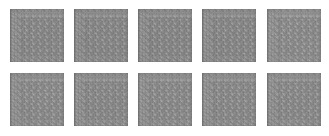

Epoch [8/150]: 6.1s  Loss D: 1.2138999700546265,  Loss G: 0.557699978351593


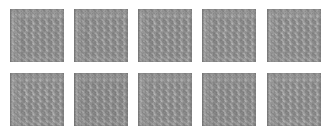

Epoch [9/150]: 6.0s  Loss D: 1.169600009918213,  Loss G: 0.6090999841690063


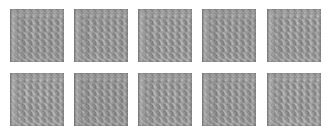

Epoch [10/150]: 6.4s  Loss D: 1.138200044631958,  Loss G: 0.6700999736785889


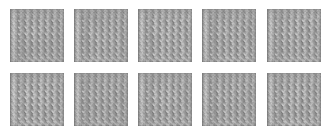

Epoch [11/150]: 6.1s  Loss D: 1.1174999475479126,  Loss G: 0.7283999919891357


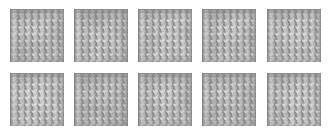

Epoch [12/150]: 6.1s  Loss D: 1.1282000541687012,  Loss G: 0.7605000138282776


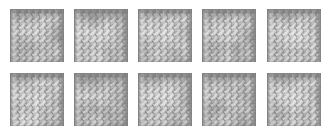

Epoch [13/150]: 6.1s  Loss D: 1.1658999919891357,  Loss G: 0.7886999845504761


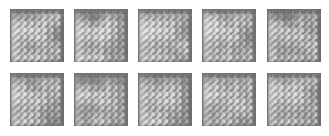

Epoch [14/150]: 6.1s  Loss D: 1.235700011253357,  Loss G: 0.79339998960495


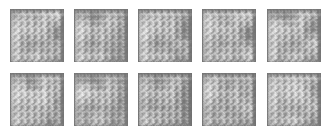

Epoch [15/150]: 6.6s  Loss D: 1.3472000360488892,  Loss G: 0.7246999740600586


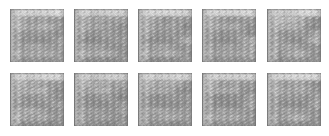

Epoch [16/150]: 6.0s  Loss D: 1.4347000122070312,  Loss G: 0.7297999858856201


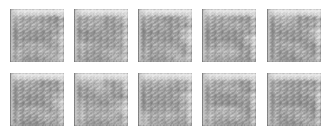

Epoch [17/150]: 6.0s  Loss D: 1.503000020980835,  Loss G: 0.6917999982833862


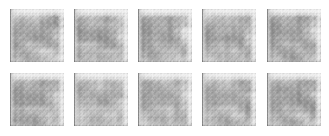

Epoch [18/150]: 6.1s  Loss D: 1.4717999696731567,  Loss G: 0.6381999850273132


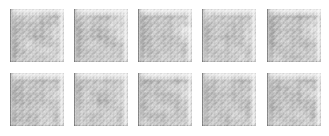

Epoch [19/150]: 6.0s  Loss D: 1.4438999891281128,  Loss G: 0.5916000008583069


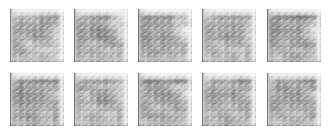

Epoch [20/150]: 6.3s  Loss D: 1.4205000400543213,  Loss G: 0.7495999932289124


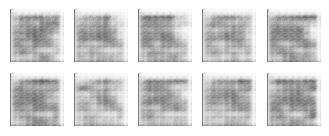

Epoch [21/150]: 6.1s  Loss D: 1.4271999597549438,  Loss G: 0.7760999798774719


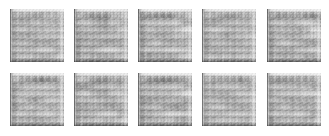

Epoch [22/150]: 6.1s  Loss D: 1.410099983215332,  Loss G: 0.6168000102043152


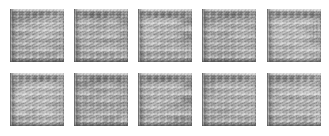

Epoch [23/150]: 6.1s  Loss D: 1.3819999694824219,  Loss G: 0.7702000141143799


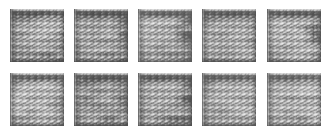

Epoch [24/150]: 6.1s  Loss D: 1.3818000555038452,  Loss G: 0.9517999887466431


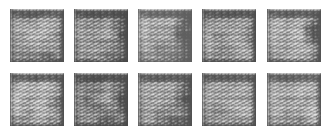

Epoch [25/150]: 6.2s  Loss D: 1.3880000114440918,  Loss G: 0.8148000240325928


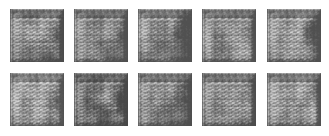

Epoch [26/150]: 6.5s  Loss D: 1.4068000316619873,  Loss G: 0.7342000007629395


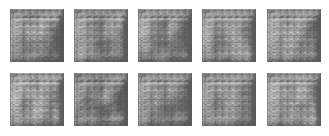

Epoch [27/150]: 6.1s  Loss D: 1.4179999828338623,  Loss G: 0.7854999899864197


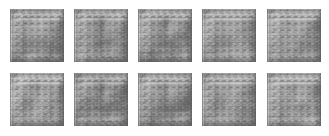

Epoch [28/150]: 6.1s  Loss D: 1.4229999780654907,  Loss G: 0.8144999742507935


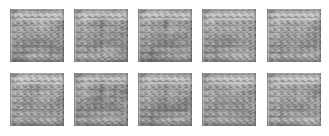

Epoch [29/150]: 6.0s  Loss D: 1.4132000207901,  Loss G: 0.7968000173568726


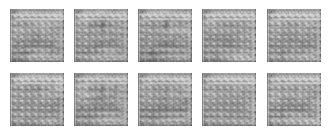

Epoch [30/150]: 6.3s  Loss D: 1.4185999631881714,  Loss G: 0.7989000082015991


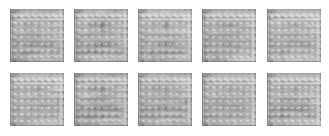

Epoch [31/150]: 6.1s  Loss D: 1.4326000213623047,  Loss G: 0.7888000011444092


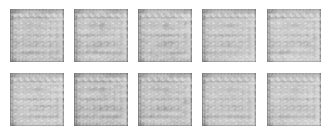

Epoch [32/150]: 6.1s  Loss D: 1.4050999879837036,  Loss G: 0.7657999992370605


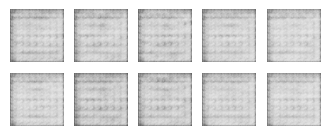

Epoch [33/150]: 6.1s  Loss D: 1.3402999639511108,  Loss G: 0.8082000017166138


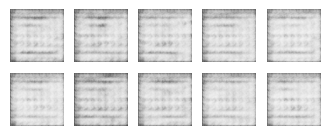

Epoch [34/150]: 6.1s  Loss D: 1.291100025177002,  Loss G: 0.8639000058174133


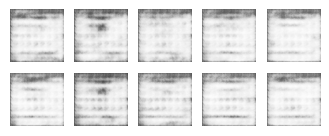

Epoch [35/150]: 6.1s  Loss D: 1.2706999778747559,  Loss G: 0.8601999878883362


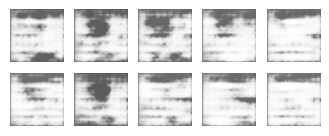

Epoch [36/150]: 6.1s  Loss D: 1.2657999992370605,  Loss G: 0.8314999938011169


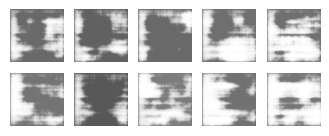

Epoch [37/150]: 6.0s  Loss D: 1.2660000324249268,  Loss G: 0.7829999923706055


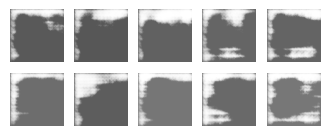

Epoch [38/150]: 6.7s  Loss D: 1.3415000438690186,  Loss G: 0.6348000168800354


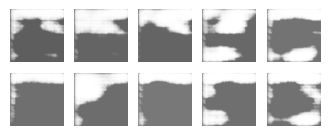

Epoch [39/150]: 6.2s  Loss D: 1.3519999980926514,  Loss G: 0.6191999912261963


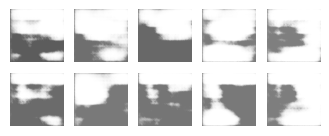

Epoch [40/150]: 6.2s  Loss D: 1.3158999681472778,  Loss G: 0.6525999903678894


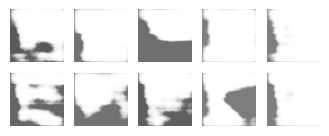

Epoch [41/150]: 6.1s  Loss D: 1.3003000020980835,  Loss G: 0.6643000245094299


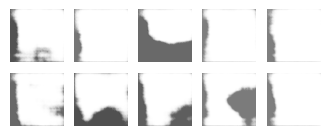

Epoch [42/150]: 6.1s  Loss D: 1.2944999933242798,  Loss G: 0.7307000160217285


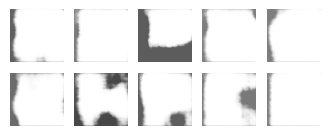

Epoch [43/150]: 6.1s  Loss D: 1.3068000078201294,  Loss G: 0.7555000185966492


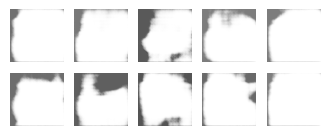

Epoch [44/150]: 6.2s  Loss D: 1.3207000494003296,  Loss G: 0.6920999884605408


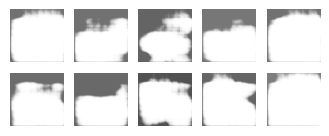

Epoch [45/150]: 6.0s  Loss D: 1.313099980354309,  Loss G: 0.7615000009536743


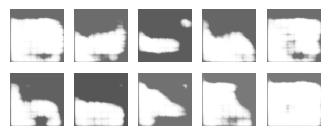

Epoch [46/150]: 6.1s  Loss D: 1.313599944114685,  Loss G: 0.7734000086784363


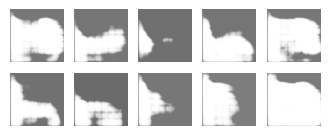

Epoch [47/150]: 6.1s  Loss D: 1.2918000221252441,  Loss G: 0.7652000188827515


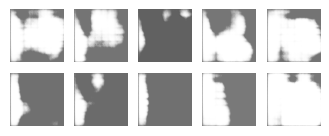

Epoch [48/150]: 6.0s  Loss D: 1.2761000394821167,  Loss G: 0.7329999804496765


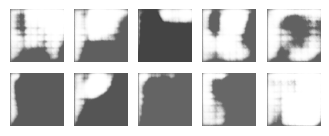

Epoch [49/150]: 6.5s  Loss D: 1.313099980354309,  Loss G: 0.718500018119812


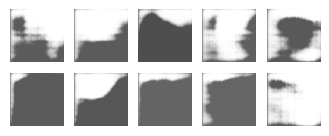

Epoch [50/150]: 6.3s  Loss D: 1.3294999599456787,  Loss G: 0.7404000163078308


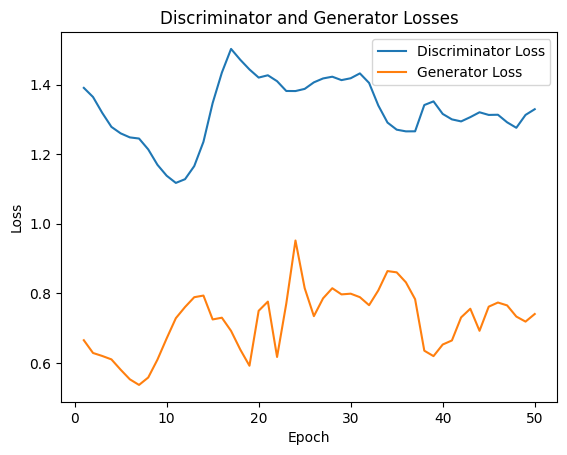

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


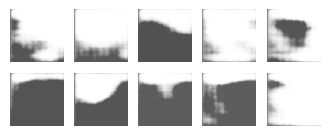

Epoch [51/150]: 6.0s  Loss D: 1.3355000019073486,  Loss G: 0.7145000100135803


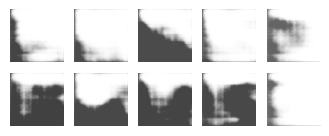

Epoch [52/150]: 6.1s  Loss D: 1.343500018119812,  Loss G: 0.7077999711036682


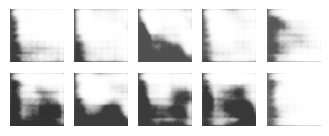

Epoch [53/150]: 6.1s  Loss D: 1.3349000215530396,  Loss G: 0.7470999956130981


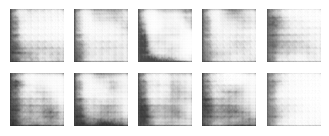

Epoch [54/150]: 6.1s  Loss D: 1.3424999713897705,  Loss G: 0.8119999766349792


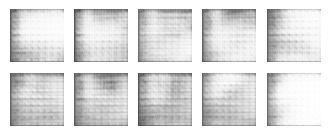

Epoch [55/150]: 6.1s  Loss D: 1.3861000537872314,  Loss G: 0.8919000029563904


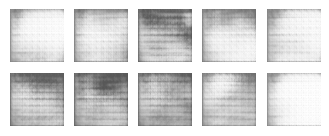

Epoch [56/150]: 6.0s  Loss D: 1.4215999841690063,  Loss G: 0.7818999886512756


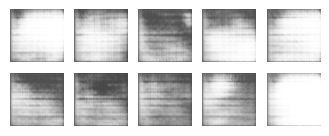

Epoch [57/150]: 6.0s  Loss D: 1.3847999572753906,  Loss G: 0.7440000176429749


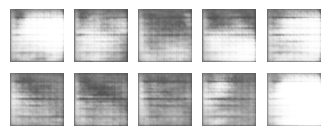

Epoch [58/150]: 6.1s  Loss D: 1.4155999422073364,  Loss G: 0.6797999739646912


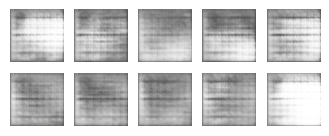

Epoch [59/150]: 6.0s  Loss D: 1.4651000499725342,  Loss G: 0.6610000133514404


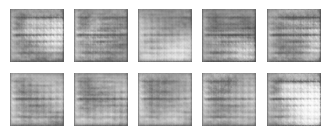

Epoch [60/150]: 7.0s  Loss D: 1.4941999912261963,  Loss G: 0.6499000191688538


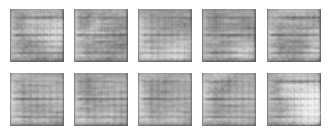

Epoch [61/150]: 6.1s  Loss D: 1.4383000135421753,  Loss G: 0.6887000203132629


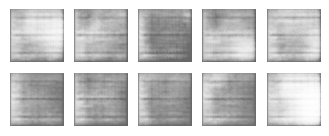

Epoch [62/150]: 6.1s  Loss D: 1.3384000062942505,  Loss G: 0.7232000231742859


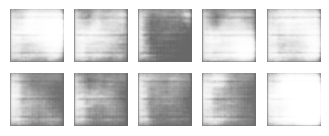

Epoch [63/150]: 6.2s  Loss D: 1.2975000143051147,  Loss G: 0.7160000205039978


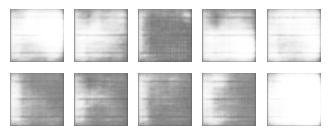

Epoch [64/150]: 6.0s  Loss D: 1.3046000003814697,  Loss G: 0.6733999848365784


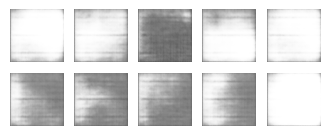

Epoch [65/150]: 6.2s  Loss D: 1.3205000162124634,  Loss G: 0.6744999885559082


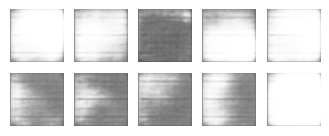

Epoch [66/150]: 6.1s  Loss D: 1.3353999853134155,  Loss G: 0.659500002861023


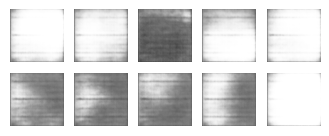

Epoch [67/150]: 6.1s  Loss D: 1.3358999490737915,  Loss G: 0.6711999773979187


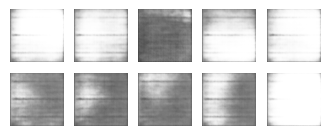

Epoch [68/150]: 6.1s  Loss D: 1.335800051689148,  Loss G: 0.6793000102043152


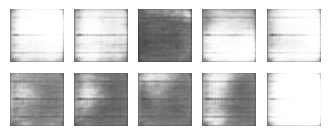

Epoch [69/150]: 6.1s  Loss D: 1.3365999460220337,  Loss G: 0.6779999732971191


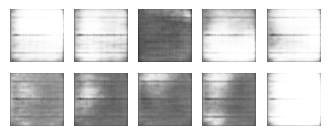

Epoch [70/150]: 6.4s  Loss D: 1.3389999866485596,  Loss G: 0.6891000270843506


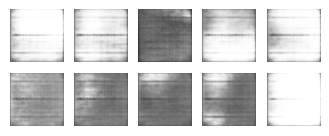

Epoch [71/150]: 6.1s  Loss D: 1.3436000347137451,  Loss G: 0.694100022315979


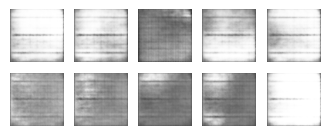

Epoch [72/150]: 6.6s  Loss D: 1.3616000413894653,  Loss G: 0.6809999942779541


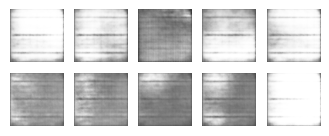

Epoch [73/150]: 6.1s  Loss D: 1.3849999904632568,  Loss G: 0.7042999863624573


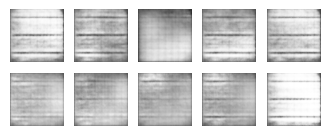

Epoch [74/150]: 6.1s  Loss D: 1.4212000370025635,  Loss G: 0.6800000071525574


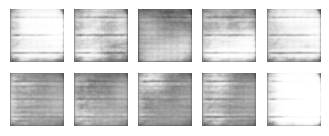

Epoch [75/150]: 6.2s  Loss D: 1.4478000402450562,  Loss G: 0.7876999974250793


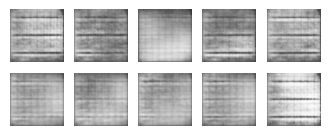

Epoch [76/150]: 6.1s  Loss D: 1.455299973487854,  Loss G: 0.6305000185966492


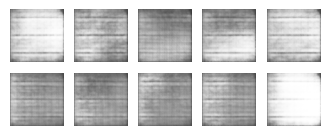

Epoch [77/150]: 6.2s  Loss D: 1.436400055885315,  Loss G: 0.7739999890327454


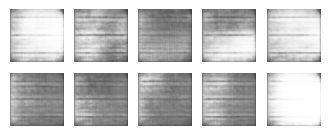

Epoch [78/150]: 6.1s  Loss D: 1.4119000434875488,  Loss G: 0.6657000184059143


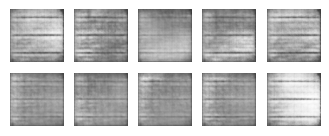

Epoch [79/150]: 6.1s  Loss D: 1.3885999917984009,  Loss G: 0.6297000050544739


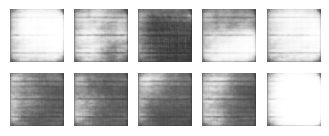

Epoch [80/150]: 6.4s  Loss D: 1.3645999431610107,  Loss G: 0.779699981212616


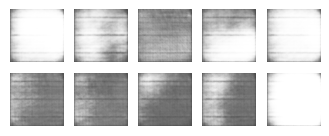

Epoch [81/150]: 6.0s  Loss D: 1.3414000272750854,  Loss G: 0.6373999714851379


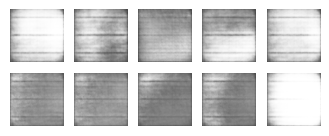

Epoch [82/150]: 6.1s  Loss D: 1.3342000246047974,  Loss G: 0.6114000082015991


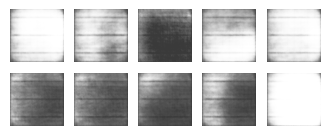

Epoch [83/150]: 6.1s  Loss D: 1.327299952507019,  Loss G: 0.7408000230789185


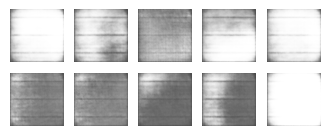

Epoch [84/150]: 6.6s  Loss D: 1.3279000520706177,  Loss G: 0.6322000026702881


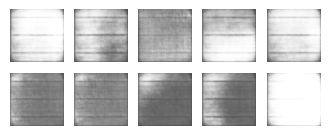

Epoch [85/150]: 6.3s  Loss D: 1.330899953842163,  Loss G: 0.666700005531311


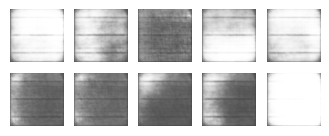

Epoch [86/150]: 6.1s  Loss D: 1.3438999652862549,  Loss G: 0.701200008392334


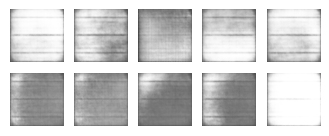

Epoch [87/150]: 6.0s  Loss D: 1.3575999736785889,  Loss G: 0.6381000280380249


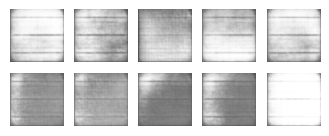

Epoch [88/150]: 6.0s  Loss D: 1.3801000118255615,  Loss G: 0.6988999843597412


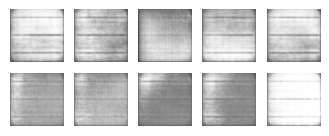

Epoch [89/150]: 6.1s  Loss D: 1.4062999486923218,  Loss G: 0.6643999814987183


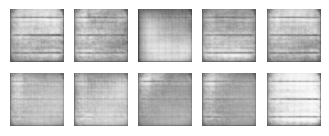

Epoch [90/150]: 6.3s  Loss D: 1.4296000003814697,  Loss G: 0.6741999983787537


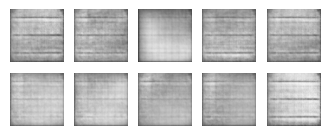

Epoch [91/150]: 6.1s  Loss D: 1.4335999488830566,  Loss G: 0.6947000026702881


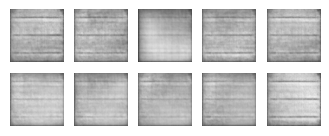

Epoch [92/150]: 6.1s  Loss D: 1.4200999736785889,  Loss G: 0.6671000123023987


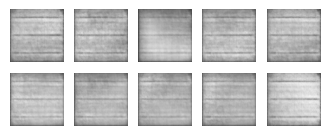

Epoch [93/150]: 6.1s  Loss D: 1.3950999975204468,  Loss G: 0.6930000185966492


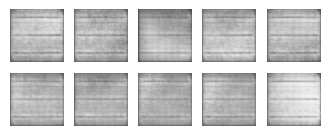

Epoch [94/150]: 6.0s  Loss D: 1.374899983406067,  Loss G: 0.6973999738693237


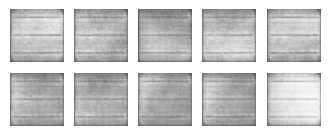

Epoch [95/150]: 6.6s  Loss D: 1.3547999858856201,  Loss G: 0.718999981880188


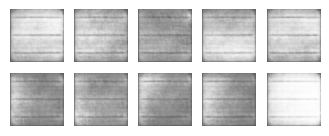

Epoch [96/150]: 6.1s  Loss D: 1.3457000255584717,  Loss G: 0.7312999963760376


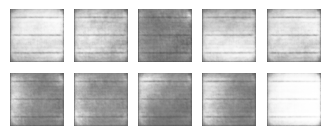

Epoch [97/150]: 6.0s  Loss D: 1.3437999486923218,  Loss G: 0.7006999850273132


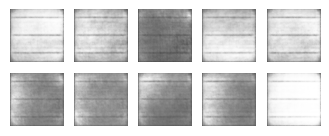

Epoch [98/150]: 6.1s  Loss D: 1.3494000434875488,  Loss G: 0.7161999940872192


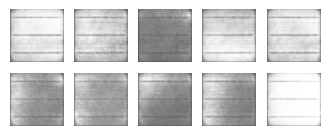

Epoch [99/150]: 6.1s  Loss D: 1.3616000413894653,  Loss G: 0.6998000144958496


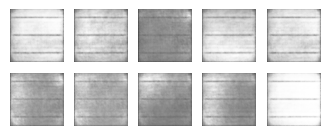

Epoch [100/150]: 6.3s  Loss D: 1.371999979019165,  Loss G: 0.7145000100135803


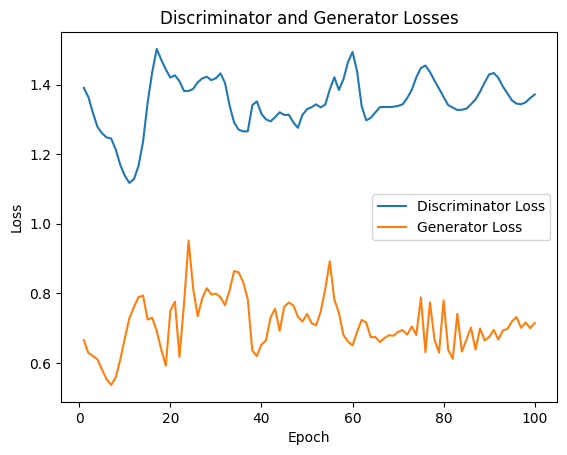

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


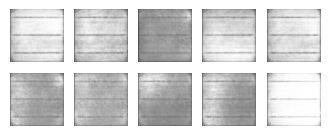

Epoch [101/150]: 6.1s  Loss D: 1.3839000463485718,  Loss G: 0.7267000079154968


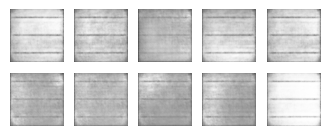

Epoch [102/150]: 6.1s  Loss D: 1.3982000350952148,  Loss G: 0.7113000154495239


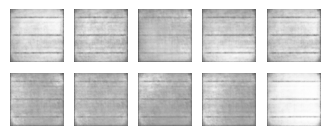

Epoch [103/150]: 6.0s  Loss D: 1.4017000198364258,  Loss G: 0.7207000255584717


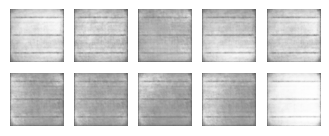

Epoch [104/150]: 6.1s  Loss D: 1.3985999822616577,  Loss G: 0.7081999778747559


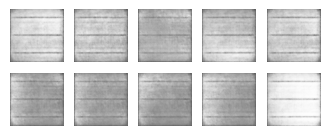

Epoch [105/150]: 6.1s  Loss D: 1.3878999948501587,  Loss G: 0.6850000023841858


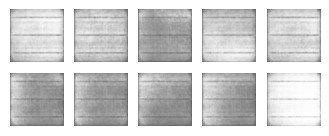

Epoch [106/150]: 6.6s  Loss D: 1.378000020980835,  Loss G: 0.701200008392334


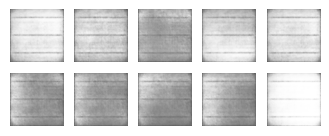

Epoch [107/150]: 6.0s  Loss D: 1.3681999444961548,  Loss G: 0.6888999938964844


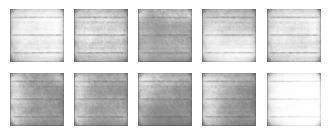

Epoch [108/150]: 6.1s  Loss D: 1.3614000082015991,  Loss G: 0.6812000274658203


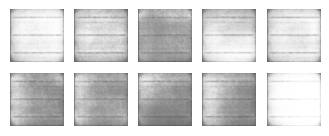

Epoch [109/150]: 6.1s  Loss D: 1.3603999614715576,  Loss G: 0.6905999779701233


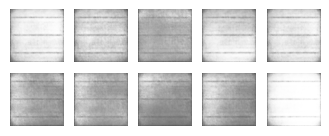

Epoch [110/150]: 6.4s  Loss D: 1.36489999294281,  Loss G: 0.6805999875068665


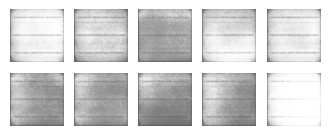

Epoch [111/150]: 6.1s  Loss D: 1.3686000108718872,  Loss G: 0.7153000235557556


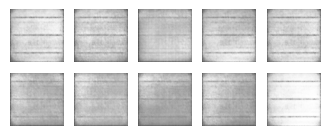

Epoch [112/150]: 6.1s  Loss D: 1.37909996509552,  Loss G: 0.6618000268936157


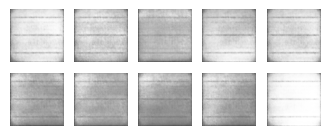

Epoch [113/150]: 6.1s  Loss D: 1.3875999450683594,  Loss G: 0.7390000224113464


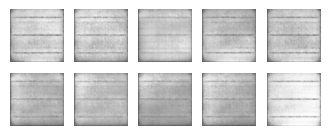

Epoch [114/150]: 6.1s  Loss D: 1.3944000005722046,  Loss G: 0.6561999917030334


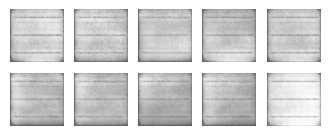

Epoch [115/150]: 6.1s  Loss D: 1.3902000188827515,  Loss G: 0.7186999917030334


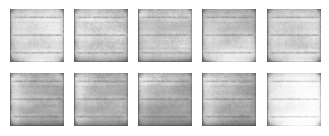

Epoch [116/150]: 6.2s  Loss D: 1.384600043296814,  Loss G: 0.703499972820282


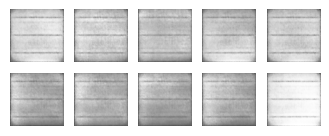

Epoch [117/150]: 6.1s  Loss D: 1.3772000074386597,  Loss G: 0.6930000185966492


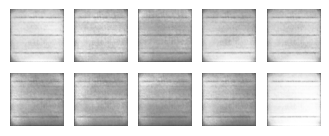

Epoch [118/150]: 6.6s  Loss D: 1.371500015258789,  Loss G: 0.7062000036239624


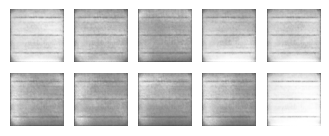

Epoch [119/150]: 6.2s  Loss D: 1.375,  Loss G: 0.6976000070571899


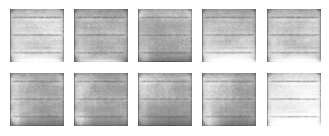

Epoch [120/150]: 6.4s  Loss D: 1.3818999528884888,  Loss G: 0.6916999816894531


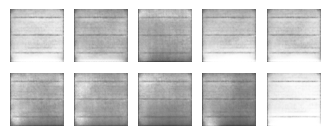

Epoch [121/150]: 6.1s  Loss D: 1.385699987411499,  Loss G: 0.7174000144004822


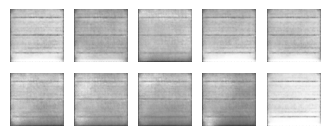

Epoch [122/150]: 6.1s  Loss D: 1.3896000385284424,  Loss G: 0.6789000034332275


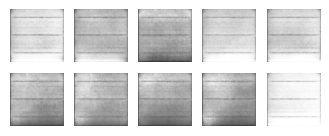

Epoch [123/150]: 6.0s  Loss D: 1.3924000263214111,  Loss G: 0.7319999933242798


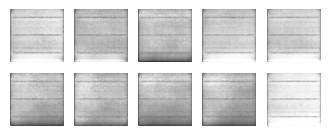

Epoch [124/150]: 6.1s  Loss D: 1.392199993133545,  Loss G: 0.684499979019165


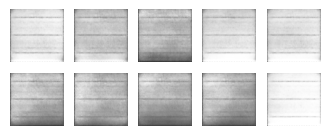

Epoch [125/150]: 6.1s  Loss D: 1.3920999765396118,  Loss G: 0.7312999963760376


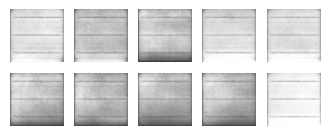

Epoch [126/150]: 6.2s  Loss D: 1.3907999992370605,  Loss G: 0.6850000023841858


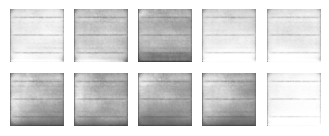

Epoch [127/150]: 6.1s  Loss D: 1.3907999992370605,  Loss G: 0.73580002784729


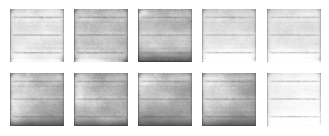

Epoch [128/150]: 6.1s  Loss D: 1.3863999843597412,  Loss G: 0.6845999956130981


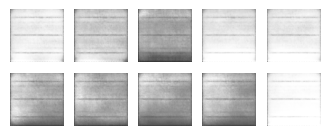

Epoch [129/150]: 6.1s  Loss D: 1.3860000371932983,  Loss G: 0.7226999998092651


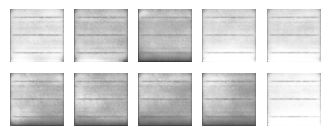

Epoch [130/150]: 6.9s  Loss D: 1.3858000040054321,  Loss G: 0.6833000183105469


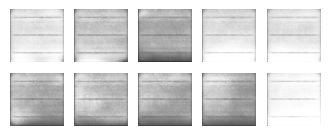

Epoch [131/150]: 6.3s  Loss D: 1.3901000022888184,  Loss G: 0.7174000144004822


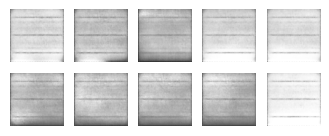

Epoch [132/150]: 6.1s  Loss D: 1.389299988746643,  Loss G: 0.6780999898910522


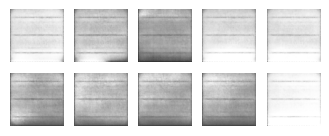

Epoch [133/150]: 6.1s  Loss D: 1.3904999494552612,  Loss G: 0.7146999835968018


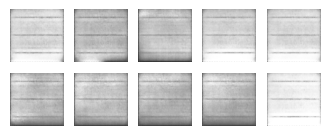

Epoch [134/150]: 6.2s  Loss D: 1.3914999961853027,  Loss G: 0.666700005531311


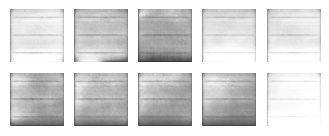

Epoch [135/150]: 6.2s  Loss D: 1.3897000551223755,  Loss G: 0.7261000275611877


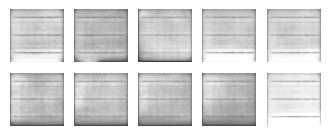

Epoch [136/150]: 6.0s  Loss D: 1.3878999948501587,  Loss G: 0.652899980545044


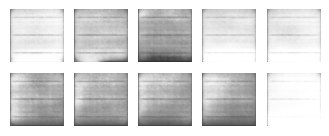

Epoch [137/150]: 6.1s  Loss D: 1.388100028038025,  Loss G: 0.7476000189781189


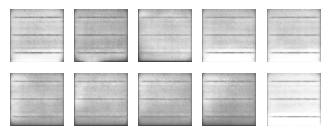

Epoch [138/150]: 6.1s  Loss D: 1.3867000341415405,  Loss G: 0.6478999853134155


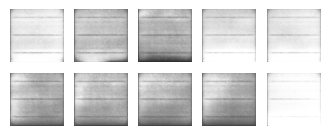

Epoch [139/150]: 6.1s  Loss D: 1.389299988746643,  Loss G: 0.7437000274658203


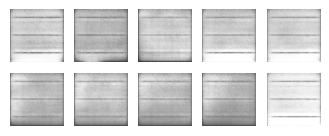

Epoch [140/150]: 6.4s  Loss D: 1.3882999420166016,  Loss G: 0.6531000137329102


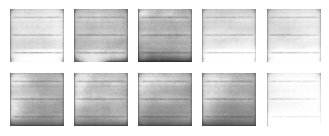

Epoch [141/150]: 6.5s  Loss D: 1.3873000144958496,  Loss G: 0.737500011920929


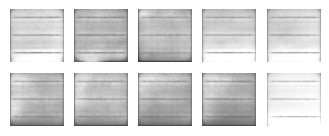

Epoch [142/150]: 6.1s  Loss D: 1.3863999843597412,  Loss G: 0.6739000082015991


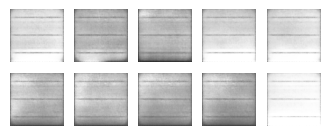

Epoch [143/150]: 6.1s  Loss D: 1.3885999917984009,  Loss G: 0.7106999754905701


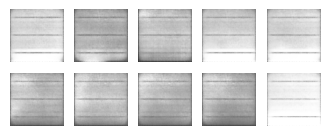

Epoch [144/150]: 6.1s  Loss D: 1.3875000476837158,  Loss G: 0.6816999912261963


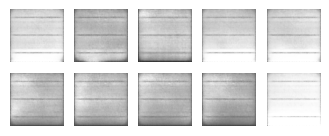

Epoch [145/150]: 6.2s  Loss D: 1.3874000310897827,  Loss G: 0.698199987411499


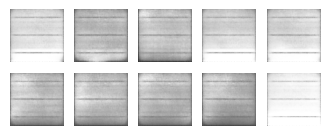

Epoch [146/150]: 6.1s  Loss D: 1.3845000267028809,  Loss G: 0.692799985408783


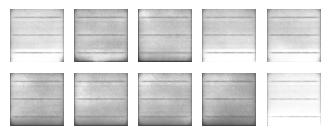

Epoch [147/150]: 6.1s  Loss D: 1.3878999948501587,  Loss G: 0.6873999834060669


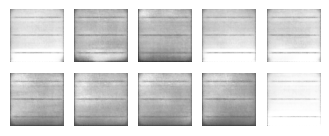

Epoch [148/150]: 6.2s  Loss D: 1.3868000507354736,  Loss G: 0.7124999761581421


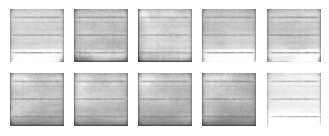

Epoch [149/150]: 6.1s  Loss D: 1.3871999979019165,  Loss G: 0.6585000157356262


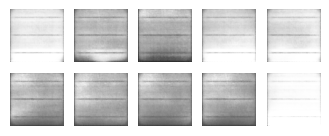

Epoch [150/150]: 6.4s  Loss D: 1.3858000040054321,  Loss G: 0.7524999976158142


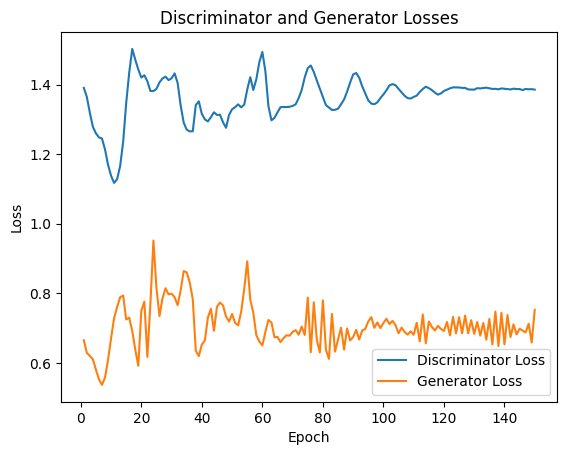

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


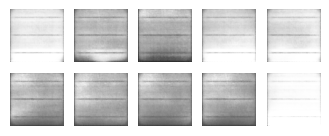

In [35]:
# Run Training

d_losses, g_losses = train(train_dataset, 150)

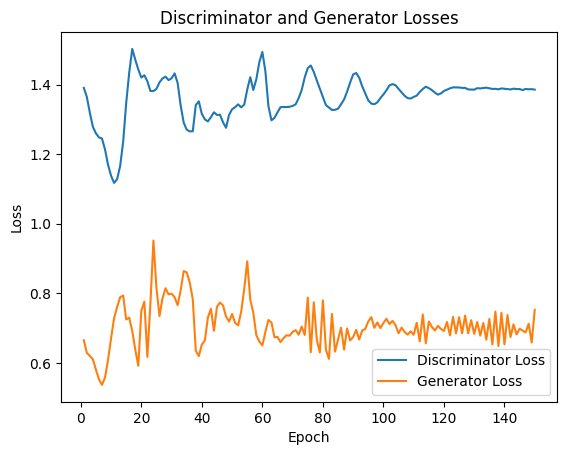

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


In [36]:
# Visualize losses

visualize_losses(d_losses, g_losses)
print(f"Discriminator Learning Rate: {lr_D}")
print(f"Generator Learning Rate: {lr_G}")

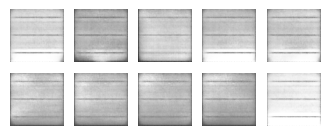

Epoch [1/50]: 6.6s  Loss D: 1.3828999996185303,  Loss G: 0.6442999839782715


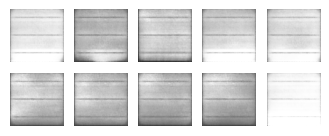

Epoch [2/50]: 6.1s  Loss D: 1.3832999467849731,  Loss G: 0.7342000007629395


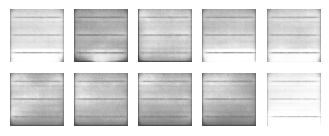

Epoch [3/50]: 6.1s  Loss D: 1.385200023651123,  Loss G: 0.6832000017166138


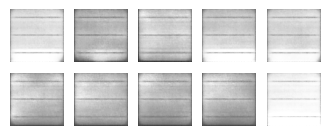

Epoch [4/50]: 6.1s  Loss D: 1.3847999572753906,  Loss G: 0.6992999911308289


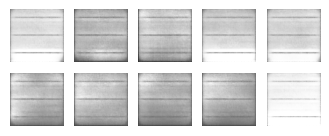

Epoch [5/50]: 6.1s  Loss D: 1.3818000555038452,  Loss G: 0.7024000287055969


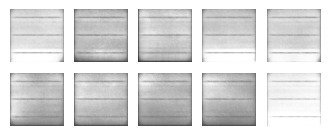

Epoch [6/50]: 6.0s  Loss D: 1.3839999437332153,  Loss G: 0.689300000667572


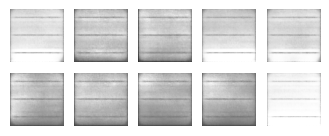

Epoch [7/50]: 6.0s  Loss D: 1.3841999769210815,  Loss G: 0.7074999809265137


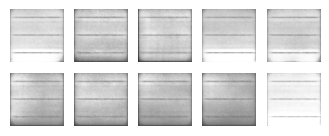

Epoch [8/50]: 6.3s  Loss D: 1.382099986076355,  Loss G: 0.6832000017166138


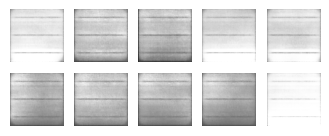

Epoch [9/50]: 6.1s  Loss D: 1.3837000131607056,  Loss G: 0.7268999814987183


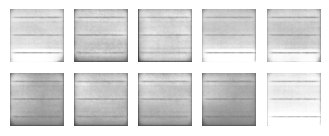

Epoch [10/50]: 6.3s  Loss D: 1.3825000524520874,  Loss G: 0.6658999919891357


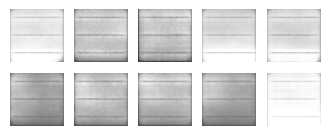

Epoch [11/50]: 6.1s  Loss D: 1.3818000555038452,  Loss G: 0.7278000116348267


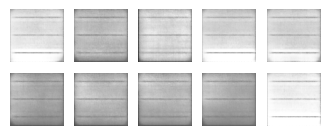

Epoch [12/50]: 6.1s  Loss D: 1.3844000101089478,  Loss G: 0.6693000197410583


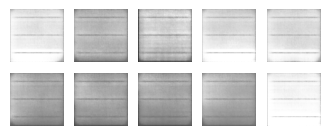

Epoch [13/50]: 6.7s  Loss D: 1.3812999725341797,  Loss G: 0.7221999764442444


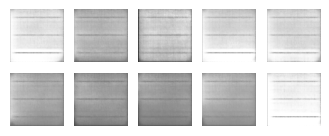

Epoch [14/50]: 6.1s  Loss D: 1.3844000101089478,  Loss G: 0.6919000148773193


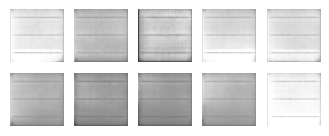

Epoch [15/50]: 6.1s  Loss D: 1.3859000205993652,  Loss G: 0.696399986743927


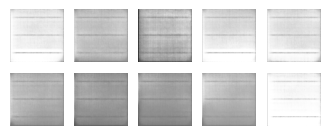

Epoch [16/50]: 6.1s  Loss D: 1.3883999586105347,  Loss G: 0.7092999815940857


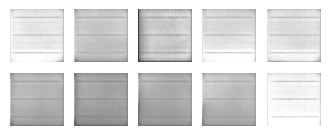

Epoch [17/50]: 6.1s  Loss D: 1.3890000581741333,  Loss G: 0.6793000102043152


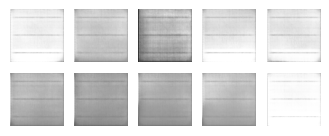

Epoch [18/50]: 6.1s  Loss D: 1.3931000232696533,  Loss G: 0.7161999940872192


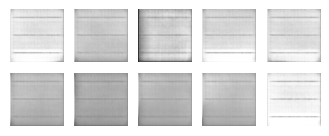

Epoch [19/50]: 6.2s  Loss D: 1.3901000022888184,  Loss G: 0.6704000234603882


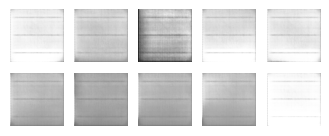

Epoch [20/50]: 6.4s  Loss D: 1.391800045967102,  Loss G: 0.7293999791145325


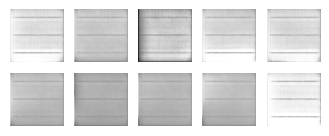

Epoch [21/50]: 6.1s  Loss D: 1.3906999826431274,  Loss G: 0.6679999828338623


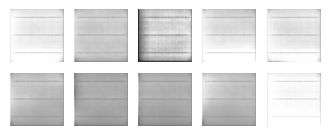

Epoch [22/50]: 6.1s  Loss D: 1.392199993133545,  Loss G: 0.71670001745224


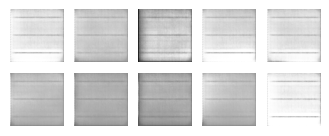

Epoch [23/50]: 6.1s  Loss D: 1.3934999704360962,  Loss G: 0.6690999865531921


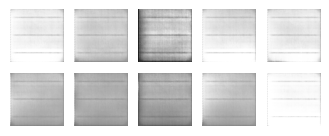

Epoch [24/50]: 6.7s  Loss D: 1.389799952507019,  Loss G: 0.7239999771118164


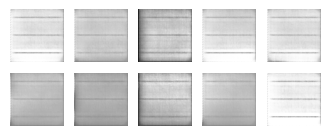

Epoch [25/50]: 6.1s  Loss D: 1.3913999795913696,  Loss G: 0.6653000116348267


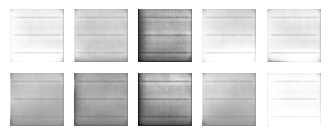

Epoch [26/50]: 6.1s  Loss D: 1.3884999752044678,  Loss G: 0.7243000268936157


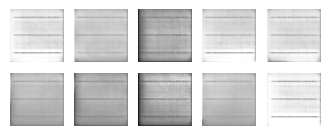

Epoch [27/50]: 6.2s  Loss D: 1.3925000429153442,  Loss G: 0.660099983215332


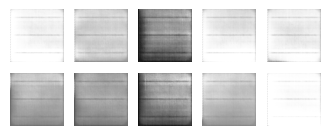

Epoch [28/50]: 6.1s  Loss D: 1.3907999992370605,  Loss G: 0.7524999976158142


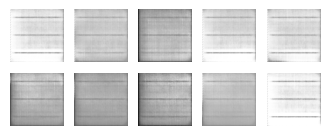

Epoch [29/50]: 6.2s  Loss D: 1.3919999599456787,  Loss G: 0.6389999985694885


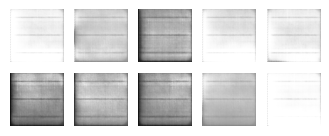

Epoch [30/50]: 6.5s  Loss D: 1.3899999856948853,  Loss G: 0.7591999769210815


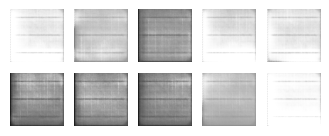

Epoch [31/50]: 6.1s  Loss D: 1.3889000415802002,  Loss G: 0.6656000018119812


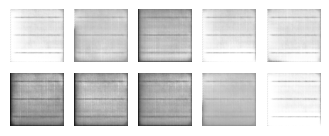

Epoch [32/50]: 6.2s  Loss D: 1.3890999555587769,  Loss G: 0.6870999932289124


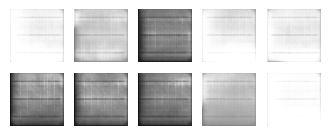

Epoch [33/50]: 6.1s  Loss D: 1.38919997215271,  Loss G: 0.7488999962806702


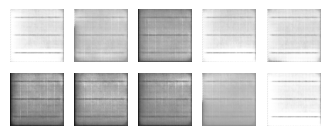

Epoch [34/50]: 6.1s  Loss D: 1.3904000520706177,  Loss G: 0.6322000026702881


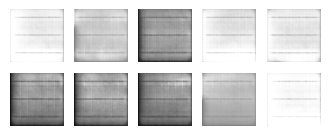

Epoch [35/50]: 6.6s  Loss D: 1.3901000022888184,  Loss G: 0.7479000091552734


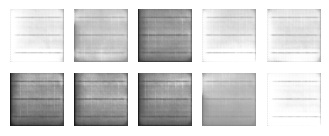

Epoch [36/50]: 6.1s  Loss D: 1.3883999586105347,  Loss G: 0.6693999767303467


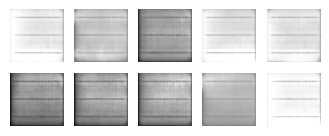

Epoch [37/50]: 6.0s  Loss D: 1.3890000581741333,  Loss G: 0.7002000212669373


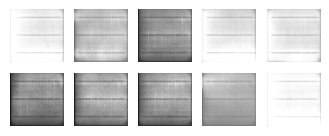

Epoch [38/50]: 6.1s  Loss D: 1.3871999979019165,  Loss G: 0.7224000096321106


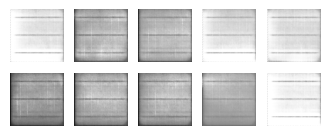

Epoch [39/50]: 6.1s  Loss D: 1.3884999752044678,  Loss G: 0.6473000049591064


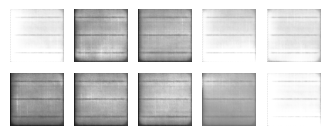

Epoch [40/50]: 6.3s  Loss D: 1.392899990081787,  Loss G: 0.7383999824523926


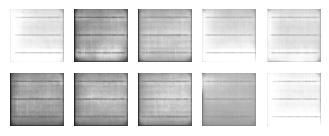

Epoch [41/50]: 6.0s  Loss D: 1.389299988746643,  Loss G: 0.6601999998092651


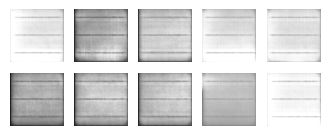

Epoch [42/50]: 6.1s  Loss D: 1.3863999843597412,  Loss G: 0.7002000212669373


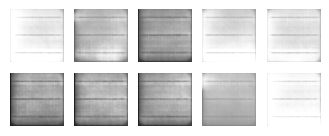

Epoch [43/50]: 6.1s  Loss D: 1.388100028038025,  Loss G: 0.7203999757766724


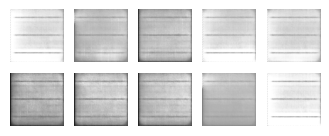

Epoch [44/50]: 6.0s  Loss D: 1.3882999420166016,  Loss G: 0.6518999934196472


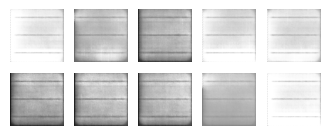

Epoch [45/50]: 6.1s  Loss D: 1.3871999979019165,  Loss G: 0.7335000038146973


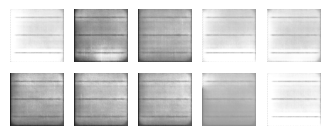

Epoch [46/50]: 6.0s  Loss D: 1.3865000009536743,  Loss G: 0.6805999875068665


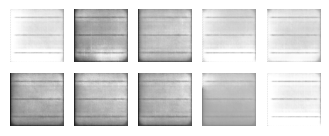

Epoch [47/50]: 6.6s  Loss D: 1.3880000114440918,  Loss G: 0.6895999908447266


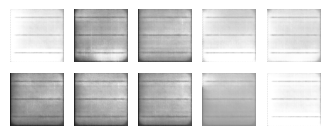

Epoch [48/50]: 6.1s  Loss D: 1.3877999782562256,  Loss G: 0.7028999924659729


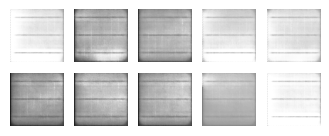

Epoch [49/50]: 6.1s  Loss D: 1.385200023651123,  Loss G: 0.690500020980835


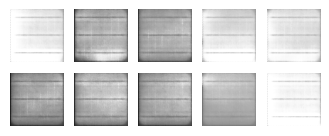

Epoch [50/50]: 6.3s  Loss D: 1.3870999813079834,  Loss G: 0.7009000182151794


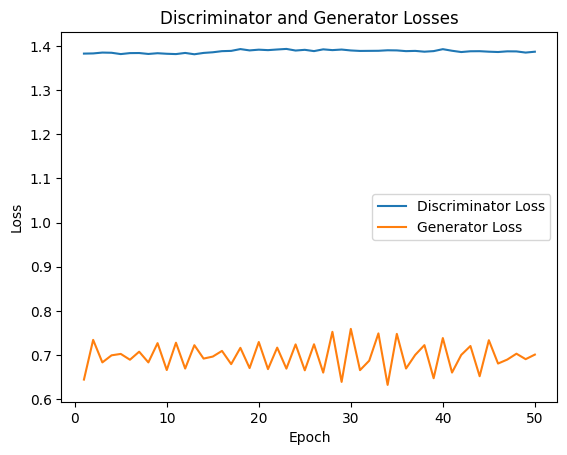

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


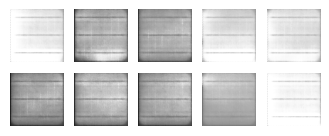

In [37]:
# Train more

d_losses_2, g_losses_2 = train(train_dataset, 50)

In [38]:
for l in d_losses_2:
    d_losses.append(l)

for l in g_losses_2:
    g_losses.append(l)

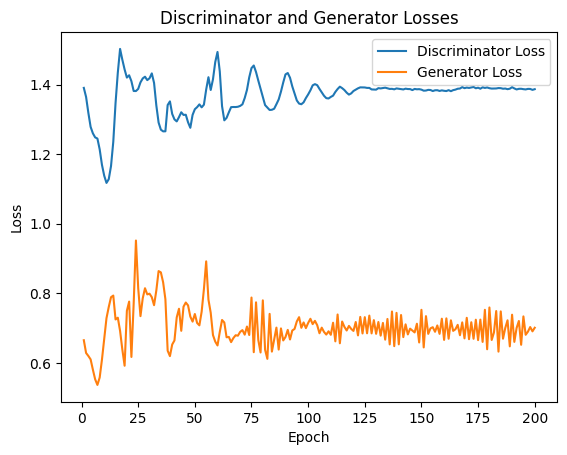

Discriminator Learning Rate: 3e-06
Generator Learning Rate: 0.0003


In [39]:
# Visualize losses

visualize_losses(d_losses, g_losses)
print(f"Discriminator Learning Rate: {lr_D}")
print(f"Generator Learning Rate: {lr_G}")

In [ ]:
np.save("d_losses.npy", d_losses)
np.save("g_losses.npy", g_losses)

## Structural Similarity Index (SSIM)

In [142]:
seed1 = tf.random.normal([100, noise_dim])

In [143]:
predictions = generator(seed1, training=False)

In [144]:
file_paths = [os.path.join(DATASET_FOLDER_PATH, fname) for fname in os.listdir(DATASET_FOLDER_PATH)]

# Step 4: Define a function to load and preprocess the images
def load_and_preprocess_image(file_path):
    # Load the raw data from the file
    img = tf.io.read_file(file_path)
    
    # Decode the JPEG/PNG image to a uint8 tensor
    img = tf.image.decode_jpeg(img, channels=channels_img)  # Change channels according to your images
    
    # Normalize the pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize the image to your desired size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Specify your desired height and width
    return img

In [145]:
original_images = []
for i in range(100):
    original_images.append(load_and_preprocess_image(file_paths[i]))

original_images = (np.array(original_images) * 2) - 1

In [146]:
print(original_images.shape)
print(predictions.shape)

(100, 256, 256, 1)
(100, 256, 256, 1)


In [149]:
ssim_values = []

for original_img, generated_img in zip(original_images, predictions):
    # Calculate SSIM
    ssim = tf.image.ssim(original_img, generated_img, max_val=2.0)
    ssim_values.append(ssim)

# Calculate average SSIM
average_ssim = tf.reduce_mean(ssim_values)

print(f"Average SSIM of {len(original_images)} samples:", average_ssim.numpy())

Average SSIM of 100 samples: 0.13909027


In [126]:
np.max(original_images)

0.8431374

In [127]:
np.min(original_images)

-0.90318626

In [128]:
np.max(predictions)

1.0

In [129]:
np.min(predictions)

-1.0